# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder 
from lightgbm import LGBMRegressor
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

ПРОСМАТРИВАЕМ ДАННЫЕ

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
display(data.head())
print(data.info())
display(data.describe())
print('Кол-во дубликатов:', data.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Кол-во дубликатов: 4


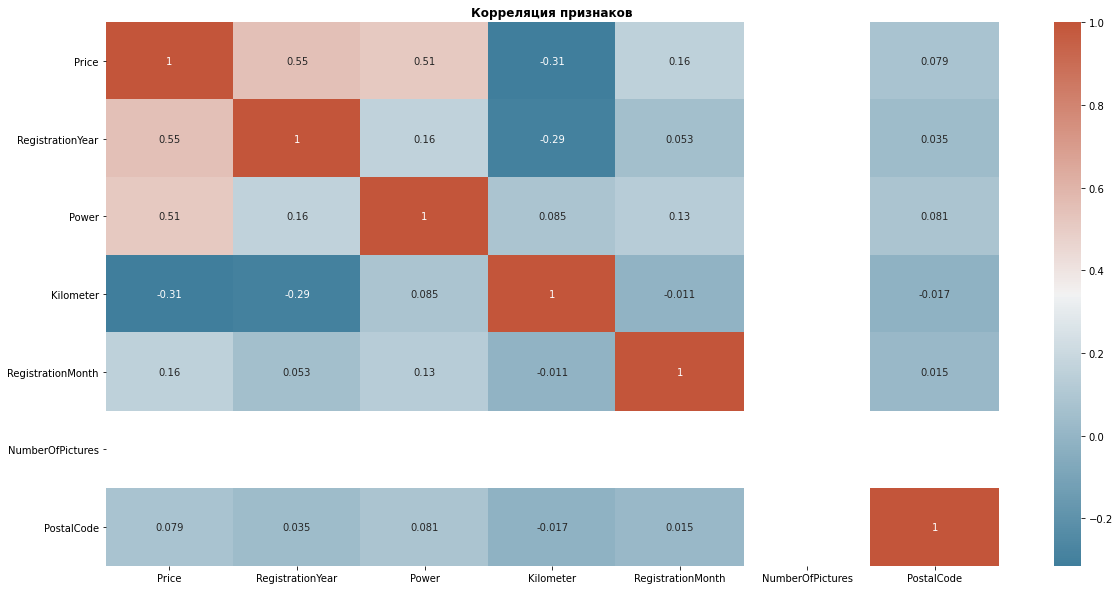

In [5]:
plt.figure(figsize=(20, 10))
plt.title('Корреляция признаков', weight = 'bold')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(data.corr(method='spearman'), annot = True, cmap=cmap)
plt.show()

РАБОТАЕМ С ДАННЫМИ

In [6]:
# Удаляем ненужные колонки, т.к сейчас сам ищу машину, то на такие данные как DataCreated, PostalCode, RegistrationMonth,
# LastSeen, почти никогда не обращаю внимания и + можно увидеть, что корреляция с ними низкая.
# NumderOfPictures удаляем, т.к неинформативная полностью (единственное значение это 0)

data = data.drop(["DateCrawled", "DateCreated", "LastSeen", "NumberOfPictures", "PostalCode", "RegistrationMonth"], axis = 1)

Целевой признак

In [7]:
data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

In [8]:
# Т.к цена на машину в 0р ничего модели не даст, предлагаю срезать таблицу со всеми нулевыми значениями

data = data.query('Price > 0')

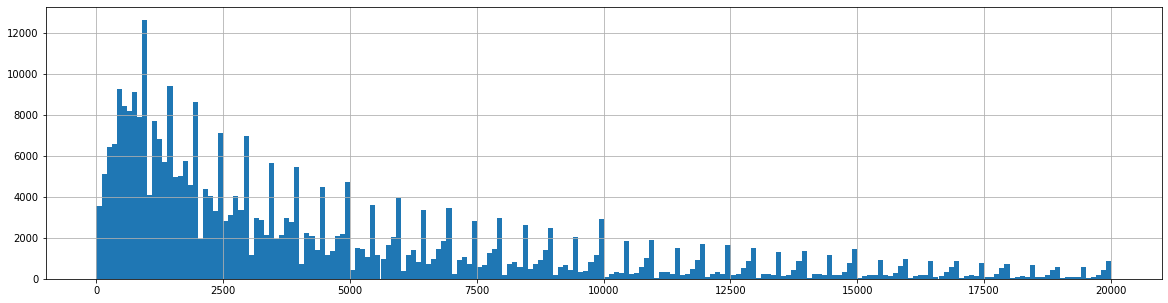

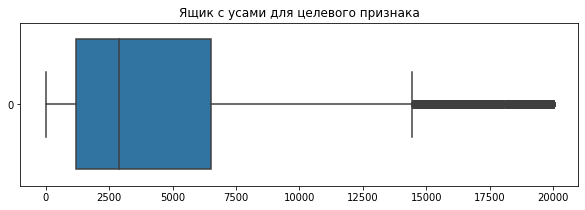

In [9]:
# Смотрю гистограмму и ящик с усами для целевого признака

data['Price'].hist(bins = 200, figsize = (20,5))

plt.figure(figsize = (10,3))
sns.boxplot(data = data['Price'], orient='h')
plt.title('Ящик с усами для целевого признака')
plt.show()

In [10]:
# Поскольку на гистограмме и ящике с усами странные данные у нуля и длинный хвост возле 15000, смотрю квантили
data['Price'].quantile([0.05, 0.95])

0.05      350.0
0.95    14800.0
Name: Price, dtype: float64

In [11]:
1 - data.query('350 <= Price <= 14800').shape[0] / data.shape[0]

0.09517254225153304

In [12]:
# Избавляюсь от 10% строк, где цена меньше 350 и больше 14800
data = data.query('350 <= Price <= 14800')

Год регистрации

In [13]:
data['RegistrationYear'].value_counts()

2000    20907
2005    20811
1999    20622
2003    19218
2001    19092
        ...  
1948        1
1949        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 130, dtype: int64

In [14]:
years = data.pivot_table(index='RegistrationYear', values='Brand', aggfunc='count')
years.columns = ['quantity']
years

,quantity
RegistrationYear,
1000,18
1001,1
1039,1
1111,1
1234,2
...,...
8500,1
8888,1
9000,2


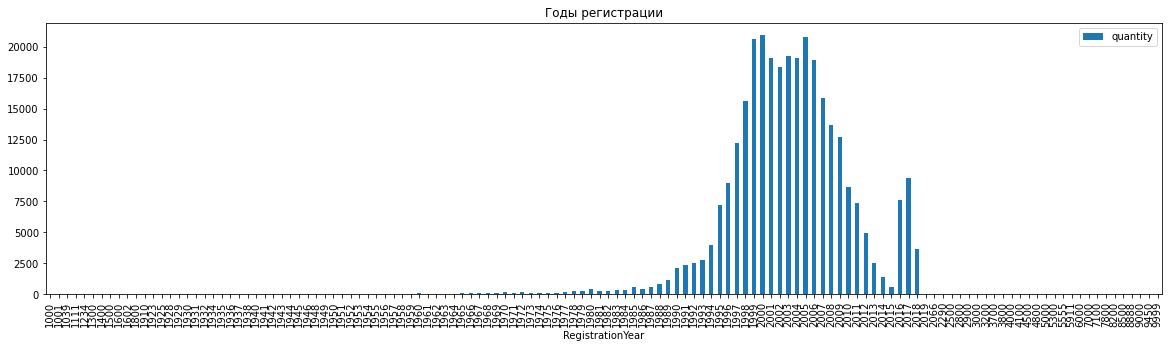

In [15]:
# Строим график
years.plot.bar(figsize = (20,5))
plt.title('Годы регистрации')
plt.show()

In [16]:
1 - data.query('1970 <= RegistrationYear <= 2016').shape[0] / data.shape[0]

0.04494429005197875

In [17]:
# Вряд ли авто ранее 1970 и позже 2016 (органичение данных) были поставлены на учет и на продажу
# поэтому оставляю в таблице только годы регистрации с 1970 по 2016:

data = data.query('1970 <= RegistrationYear <= 2016')

Мощность

In [18]:
# Смотрю значения в power
data['Power'].value_counts()

0        27026
75       20658
60       13073
150      13019
101      12113
         ...  
1703         1
1339         1
2729         1
1704         1
17019        1
Name: Power, Length: 628, dtype: int64

In [19]:
# Поскольку самое мощное по состоянию на 2024 год легковое авто имеет 1600лс,
# а самое слабое имеет 5лс,  
# то уберу из таблицы всё, что выше и ниже этих границ:
data = data.query('5 <= Power <= 1600')

Километраж

In [20]:
data['Kilometer'].value_counts()

150000    183801
125000     29206
100000     11439
90000       9069
80000       7791
70000       6578
60000       5616
50000       4491
40000       3472
30000       2949
20000       2384
5000        2300
10000        600
Name: Kilometer, dtype: int64

Данные вполне достоверны

Бренд

In [21]:
data['Brand'].value_counts()

volkswagen        58491
opel              29922
bmw               28908
mercedes_benz     24545
audi              22572
ford              18535
renault           12937
peugeot            8950
fiat               7085
seat               5416
skoda              4587
smart              4450
mazda              4447
citroen            4019
toyota             3855
nissan             3602
hyundai            2887
volvo              2570
mini               2494
mitsubishi         2286
honda              2272
kia                1912
alfa_romeo         1856
suzuki             1849
sonstige_autos     1379
chevrolet          1355
chrysler           1093
dacia               785
subaru              571
daihatsu            557
jeep                495
saab                444
porsche             398
jaguar              374
land_rover          367
daewoo              366
lancia              344
rover               328
trabant             237
lada                156
Name: Brand, dtype: int64

Дубликатов не вижу

Модель

In [22]:
# Заменяю NaN на 'unknown'
data["Model"] = data["Model"].fillna('unknown')
data['Model'].value_counts()

golf                  22615
other                 18223
3er                   16109
polo                   9734
unknown                9724
                      ...  
amarok                    3
gl                        2
serie_3                   2
range_rover_evoque        2
rangerover                1
Name: Model, Length: 250, dtype: int64

Коробка передач

In [23]:
data['Gearbox'].value_counts()

manual    214192
auto       50795
Name: Gearbox, dtype: int64

In [24]:
# В голове 3 идеи: 1. Удалить пропуски и превратить в категориальную переменную. 
# 2. Удалить пропуски и оставить как есть
# 3. Заменить пропуски на unknown и оставить как есть. <-- делаем

data["Gearbox"] = data["Gearbox"].fillna('unknown')

Ремонт

In [25]:
# Схема та же, что и с коробкой.
# Изначально заполнил на no, потому что подумал, что если не было ремонта, то чисто машинально пропускаешь этот пункт))
data["Repaired"] = data["Repaired"].fillna('unknown')

Тип кузова

In [26]:
data["VehicleType"] = data["VehicleType"].fillna('unknown')
data['VehicleType'].value_counts()

sedan          76564
small          64807
wagon          54760
bus            24471
convertible    16506
coupe          12406
unknown         9238
suv             8707
other           2237
Name: VehicleType, dtype: int64

Тип топлива

In [27]:
data["FuelType"] = data["FuelType"].fillna('unknown')
data['FuelType'].value_counts()

petrol      172172
gasoline     78732
unknown      13502
lpg           4533
cng            469
hybrid         154
other           72
electric        62
Name: FuelType, dtype: int64

In [28]:
data = data.drop_duplicates()

In [29]:
print(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232885 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             232885 non-null  int64 
 1   VehicleType       232885 non-null  object
 2   RegistrationYear  232885 non-null  int64 
 3   Gearbox           232885 non-null  object
 4   Power             232885 non-null  int64 
 5   Model             232885 non-null  object
 6   Kilometer         232885 non-null  int64 
 7   FuelType          232885 non-null  object
 8   Brand             232885 non-null  object
 9   Repaired          232885 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.5+ MB
None


,Price,RegistrationYear,Power,Kilometer
count,232885.000000,232885.000000,232885.000000,232885.000000
mean,4340.169414,2002.760891,119.824798,129216.480237
std,3612.010971,6.129859,57.009129,35648.895812
min,350.000000,1970.000000,5.000000,5000.000000
25%,1450.000000,1999.000000,80.000000,125000.000000
50%,3150.000000,2003.000000,110.000000,150000.000000
75%,6490.000000,2007.000000,145.000000,150000.000000
max,14800.000000,2016.000000,1600.000000,150000.000000


Выводы

Дубликаты объектов: было найдено 5 штук - удалены

Проверена корреляция: все в рамках разумных пределов, наиболее коррелирующими с целевым признаком являются признаки отвечающие за мощность и год

Данные были очищены от выбросов

## Обучение моделей

In [30]:
target = data['Price']
features = data.drop(['Price'], axis=1)

In [31]:
features_ohe = pd.get_dummies(features, drop_first = True)

In [32]:
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size = 0.25,
                                                                                            random_state = 12345)

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size = 0.25,
                                                                            random_state = 12345)

In [33]:
# Решил проверить оба кодирования
encoder = OrdinalEncoder()

features_train_oe = features_train[['VehicleType','FuelType','Brand','Model', 'Gearbox', 'Repaired']]
features_train_oe = pd.DataFrame(encoder.fit_transform(features_train),
                                 columns = features_train.columns,
                                 index = features_train.index)

features_test_oe = features_test[['VehicleType','FuelType','Brand','Model', 'Gearbox', 'Repaired']]
features_test_oe = pd.DataFrame(encoder.fit_transform(features_test),
                                columns=features_test.columns,
                                index=features_test.index)

Random Forest c OHE

In [ ]:
model_rf = RandomForestRegressor()
parametrs = {'n_estimators': range(1, 51, 10),
            'max_depth': range(1, 51, 10),
            'min_samples_leaf': range(1, 11, 1),
            }
grid_ohe = GridSearchCV(model_rf, parametrs, cv = 2, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 3)
grid_ohe.fit(features_train_ohe, target_train_ohe)

Fitting 2 folds for each of 250 candidates, totalling 500 fits
[CV 1/2] END max_depth=1, min_samples_leaf=1, n_estimators=1; total time=   0.5s
[CV 2/2] END max_depth=1, min_samples_leaf=1, n_estimators=1; total time=   0.5s
[CV 1/2] END max_depth=1, min_samples_leaf=1, n_estimators=11; total time=   1.2s
[CV 2/2] END max_depth=1, min_samples_leaf=1, n_estimators=11; total time=   1.2s


In [ ]:
grid_ohe.best_params_

In [ ]:
tic = time.time()
rf_ohe = RandomForestRegressor(n_estimators = grid_ohe.best_params_['n_estimators'],
                           max_depth = grid_ohe.best_params_['max_depth'],
                           min_samples_leaf = grid_ohe.best_params_['min_samples_leaf'],
                           random_state = 12345)
rf_ohe.fit(features_train_ohe, target_train_ohe)
toc = time.time()
study_rf_ohe_time = toc - tic

In [ ]:
tic = time.time()
target_predict = rf_ohe.predict(features_train_ohe)
toc = time.time()
predict_rf_ohe_time = toc - tic

In [ ]:
rmse_rf_ohe = mean_squared_error(target_train_ohe, target_predict) ** 0.5
rmse_rf_ohe

Random Forest c OE

In [ ]:
grid_oe = GridSearchCV(model_rf, parametrs, cv = 2, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 3)
grid_oe.fit(features_train_oe, target_train)

In [ ]:
grid_oe.best_params_

In [ ]:
tic = time.time()
rf_oe = RandomForestRegressor(n_estimators = grid_oe.best_params_['n_estimators'],
                           max_depth = grid_oe.best_params_['max_depth'],
                           min_samples_leaf = grid_oe.best_params_['min_samples_leaf'],
                           random_state = 12345)
rf_oe.fit(features_train_oe, target_train)
toc = time.time()
study_rf_oe_time = toc - tic

In [ ]:
tic = time.time()
target_predict = rf_oe.predict(features_train_oe)
toc = time.time()
predict_rf_oe_time = toc - tic

In [ ]:
rmse_rf_oe = mean_squared_error(target_train, target_predict) ** 0.5
rmse_rf_oe

LightGBM c OHE

In [ ]:
model_lgbmr = LGBMRegressor()  
parameters = {'num_leaves': [25, 50, 100, 200], 
               'learning_rate': [0.1, 0.3, 0.5],
              'max_depth': range(1, 51, 10)
              }

clf_ohe = GridSearchCV(model_lgbmr, parameters, cv = 2, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 3)
clf_ohe.fit(features_train_ohe, target_train_ohe)

print(clf_ohe.best_params_)

In [ ]:
tic = time.time()
model_lgbmr_ohe = LGBMRegressor(learning_rate = clf_ohe.best_params_['learning_rate'], 
                            num_leaves = clf_ohe.best_params_['num_leaves'], 
                            max_depth = clf_ohe.best_params_['max_depth'],
                            random_state = 12345)
model_lgbmr_ohe.fit(features_train_ohe, target_train_ohe)
toc = time.time()
study_lgbmr_ohe_time = toc - tic

In [ ]:
tic = time.time()
target_predict = model_lgbmr_ohe.predict(features_train_ohe)
toc = time.time()
predict_lgbmr_ohe_time = toc - tic

In [ ]:
rmse_lgbmr_ohe = mean_squared_error(target_train_ohe, target_predict) ** 0.5
rmse_lgbmr_ohe

LihgtBMR c OE

In [ ]:
clf_oe = GridSearchCV(model_lgbmr, parameters, cv = 2, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 3)
clf_oe.fit(features_train_oe, target_train)

print(clf_oe.best_params_)

In [ ]:
tic = time.time()
model_lgbmr_oe = LGBMRegressor(learning_rate = clf_oe.best_params_['learning_rate'], 
                            num_leaves = clf_oe.best_params_['num_leaves'], 
                            max_depth = clf_oe.best_params_['max_depth'],
                            random_state = 12345)
model_lgbmr_oe.fit(features_train_oe, target_train)
toc = time.time()
study_lgbmr_oe_time = toc - tic

In [ ]:
tic = time.time()
target_predict = model_lgbmr_oe.predict(features_train_oe)
toc = time.time()
predict_lgbmr_oe_time = toc - tic

In [ ]:
rmse_lgbmr_oe = mean_squared_error(target_train, target_predict) ** 0.5
rmse_lgbmr_oe

CatBoost

In [ ]:
catboost = CatBoostRegressor(loss_function = 'RMSE')
parameters_cat = {'depth': range(1, 51, 50), 
                  'learning_rate': [0.1, 0.3, 0.5]}
catboost_grid = catboost.grid_search(parameters_cat,
                                     Pool(features_train, target_train, cat_features=["VehicleType","Gearbox",
                                                                                      "Model","FuelType",
                                                                                      "Brand","Repaired"]),
                                     cv = 2,
                                     verbose = True,
                                     plot = False)

In [ ]:
catboost_grid["params"]

In [ ]:
tic = time.time()
model_cbr = CatBoostRegressor(learning_rate = catboost_grid["params"]['learning_rate'],
                              max_depth = catboost_grid["params"]['depth'],
                              random_state = 12345,
                              cat_features=["VehicleType","Gearbox",
                                            "Model","FuelType",
                                            "Brand","Repaired"])

model_cbr.fit(features_train, target_train)
toc = time.time()
study_cbr_time = toc - tic

In [ ]:
tic = time.time()
target_predict = model_cbr.predict(features_train)
toc = time.time()
predict_cbr_time = toc - tic

In [ ]:
rmse_cbr = mean_squared_error(target_train, target_predict) ** 0.5
rmse_cbr

## Анализ моделей

In [ ]:
index = ['Случайный лес с OHE',
         'Случайный лес с OE',
         'CatBoostRegressor',
         'LGBMRegressor с OHE',
         'LGBMRegressor с OE'
        ]

data = {'RMSE':[rmse_rf_ohe,
                rmse_rf_oe,
                rmse_cbr,
                rmse_lgbmr_ohe,
                rmse_lgbmr_oe
               ],
       'Время обучения модели': [study_rf_ohe_time,
                                 study_rf_oe_time,
                                study_cbr_time,
                                study_lgbmr_ohe_time,
                                study_lgbmr_oe_time
                                ],
        
        'Время предсказания модели': [predict_rf_ohe_time,
                                      predict_rf_oe_time,
                                     predict_cbr_time,
                                     predict_lgbmr_ohe_time,
                                     predict_lgbmr_oe_time
                                     ]
       }
total_data = pd.DataFrame(data=data, index=index)
total_data.sort_values(by = 'RMSE', ascending=True)
display(total_data)

Лучшей моделью по RMSE, времени обучения модели, времени предсказания модели, если считать эти параметры одинаково важными для принятия решения, является LGBMRegressor.

In [ ]:
model_lgbmr = LGBMRegressor(learning_rate = clf_ohe.best_params_['learning_rate'], 
                            num_leaves = clf_ohe.best_params_['num_leaves'], 
                            max_depth = clf_ohe.best_params_['max_depth'],
                            random_state = 12345)

model_lgbmr.fit(features_test_ohe, target_test_ohe)

target_predict = model_lgbmr.predict(features_test_ohe)

rmse_lgbmr = mean_squared_error(target_test_ohe, target_predict) ** 0.5
rmse_lgbmr

В проекте:

загрузил данные и провел их предобработку - очистку, заполнение, удаление лишних данных

сравнил 3 модели с разными гиперпараметрами и выборками

выбрал лучшую модель по 3 показателям - RMSE, время обучения и время предскзания - и провериk ее на тестовой выборке

Итог - наилучшей моделью стала LGBMRegressor с OHE, которая на финальном тестировании показала RMSE 1302, несмотря на требуемое бОльшее время на обучение и предсказание. То есть если есть время, то лучше пользоваться данной моделью